In [1]:
%load_ext autoreload
%autoreload 2
from fun import *
os.environ['QT_QPA_PLATFORM']='offscreen'

### AKAP79
* We use as reference the AKAP79 sequence in human
- **Gene:** AKAP5
- **Protein name:** AKAP79, AKAP5 ,…
- **Binding partners:** PKC,PKA, CaM, PP2B,…

#### Questions we want to address:

- Is the AKAP79 protein architecture the same in all species?
- How can we find the binding partners in the sequences? 
    - As a first step, by assesing the conservation of the msa, i.e., looking that the aligned sequences match with the reference sequence region. 
- Can we find repeated instances?
    - We can use a profile hmm for identifying binding regions and possible repetitions.
    
Disadvantages:
- One cannot conclude that a binding region is present in a species solely by looking at a msa
- the profile hmm might fail to identify binding regions, specially when few seed sequences are used for creating the model.

In [2]:
# We will use as a reference the human architecture
ref = 'Homo_sapiens'

In [3]:
# Multiple Sequence Alignment using MUSCLE
seq_filename = 'fasta_files/akap5_seq_prot.fa'
msa_filename = 'fasta_files/msa/akap5_seq_align.fa'
subprocess.call(["muscle","-in", seq_filename, "-out", msa_filename], 
                stdout=subprocess.DEVNULL,
                stderr=subprocess.STDOUT)

0

In [4]:
# Parse msa and original sequences
akap5_seqs = {fasta.id:str(fasta.seq) for fasta in SeqIO.parse(open(seq_filename),'fasta')}
akap5_msa_seqs = {fasta.id:str(fasta.seq) for fasta in SeqIO.parse(open(msa_filename),'fasta')}
host_guest_dict = species_host_to_guest_map_dic()
nwk_direct = 'nwk_trees/model_species.nwk'

### Binding partners:

### 1. Calmodulin (CaM) - WSK domain - [Patel et al. Nature (2017)](https://www.nature.com/articles/s41467-017-01715-w)

#### msa of the reference binding region

In [5]:
# calmodulin binding region - based on Patel et al.
base_string_wsk = 'RGAWASLKRLVTRRKRSESSKQQKPLEGEM'
compiled_regex = re.compile('(-)*'.join(list(base_string_wsk)))
start, end = compiled_regex.search(akap5_msa_seqs[ref]).span()

# this binding region has a motif - its importance relies 
compiled_regex_motif = re.compile('(-)*'.join(list('WASLK')))
i, iii = compiled_regex_motif.search(akap5_msa_seqs[ref]).span()
wsk_residues_idx = (i,i+2,iii-1)

filename = 'fasta_files/binding_regions/AKAP5_WSK.fa'
regions_dict, aln = seq_domain_alignment(akap5_msa_seqs,
                                         akap5_seqs,
                                         start, end,
                                         filename,
                                         motif_coords=wsk_residues_idx)

In [6]:
alv.view(aln)

Xenopus_tr GKTWATFKRLVTHKKKRHSS--LKQQSQMNSQ-
Ornithorhy QGAWAAIKHLVPHRKRSSSS--SKKQRCSEATE
Monodelphi GGTWASIRRLITRQKR-SKS--SKKQVPLDAKA
Mus_muscul -GAWASIKGLVTHRKR-SEP--AKKQKPPEAEV
Homo_sapie RGAWASLKRLVTRRKR-SES--SKQQKPLEGEM
Canis_lupu GGAWASIKRLVTRRKR-SES--SKQQKLFEAKV
Bos_taurus GGAWDSIKRLVTRRKR-SES--SKQQKPFKAKL
Sus_scrofa GGAWVSVKRLITCRKR-SDS--SKQQKPCKAKV
Anolis_car GGAWLAFKRLVTSRRR-SKSVLKKQQQSGGSRV
Gallus_gal RGAWAALKSLTKPRRGQKSS--SRKKVSSDSQV
Taeniopygi KGTWAAIKSLARPQRRQKSS--SRKKVPSDSQV
          0↑                 20↑


In general the msa seems quite well conserved. There is a variation in the second residue of the motif in which serine (S) is replaced by alanine (A). This occurs for birds, lizard and platypus.
- Is this an assembly artefact?
- What can these variations indicate?

#### Construct a hmm for identifying *calmodulin* binding regions in our model species

In [7]:
hmm_for_wsk_domain = binding_regions()
msa_filename = 'fasta_files/msa/PF03832_seed_msa.fa'
# align the seed sequences - downloaded from Pfam
hmm_for_wsk_domain.muscle_msa('profile_hmm/seed_files/PF03832_seed.fa', msa_filename)
# build the profile hmm
hmm_for_wsk_domain.build_profile_hmm("profile_hmm/hmm/WSK.hmm", msa_filename)
# search for the binding region
hmm_for_wsk_domain.search_binding_regions("profile_hmm/WSK.sto","profile_hmm/hmm/WSK.hmm",seq_filename)
wsk_hmm_hits = read_sto_files("profile_hmm/WSK.sto")

We want to know:
- How many binding regions (if any) the hmm finds per specie.
- Do the regions found coincide (overlap or overlap) with the regions aligned to the reference sequence in the msa?

In [10]:
wsk_hits_counter = dict(Counter([specie_name.rsplit('-')[0] for specie_name in wsk_hmm_hits.keys()]))
wsk_aling_coord = {specie:list(regions_dict[specie].values())[0][0] for specie in regions_dict.keys()}
hmm_hits_analysis_df(regions_dict, wsk_hits_counter, wsk_aling_coord, wsk_hmm_hits)

,specie,number of instances,aligned to ref seq in msa
0,Gallus_gallus,0,-
1,Taeniopygia_guttata,0,-
2,Xenopus_tropicalis,1,True
3,Ornithorhynchus_anatinus,1,True
4,Monodelphis_domestica,1,True
5,Mus_musculus,1,True
6,Homo_sapiens,1,True
7,Canis_lupus,1,True
8,Bos_taurus,1,True
9,Sus_scrofa,1,True


We will improve the seed file with the hmm hits and check if we can find binding sites in the species where they were not found.

In [11]:
new_seeds = {}
for s in wsk_hmm_hits.keys():
    s = s.rsplit('-')[0]
    new_seeds[s] = akap5_seqs[s][wsk_aling_coord[s][0]:wsk_aling_coord[s][1]]

hmm_for_wsk_domain.generate_seed_file('profile_hmm/seed_files/PF03832_seed.fa',
                                      new_seeds,
                                      'profile_hmm/seed_files/PF03832_seed_v2.fa')

In [15]:
hmm_for_wsk_domain = binding_regions()
msa_filename = 'fasta_files/msa/PF03832_seed_v2_msa.fa'
# align the seed sequences - downloaded from Pfam
hmm_for_wsk_domain.muscle_msa('profile_hmm/seed_files/PF03832_seed_v2.fa', msa_filename)
# build the profile hmm
hmm_for_wsk_domain.build_profile_hmm("profile_hmm/hmm/WSK_v2.hmm", msa_filename)
# search for the binding region
hmm_for_wsk_domain.search_binding_regions("profile_hmm/WSK_v2.sto","profile_hmm/hmm/WSK_v2.hmm",seq_filename)
wsk_v2_hmm_hits = read_sto_files("profile_hmm/WSK_v2.sto")

In [16]:
wsk_hits_counter_v2 = dict(Counter([specie_name.rsplit('-')[0] for specie_name in wsk_v2_hmm_hits.keys()]))
wsk_hits_counter_v2 == wsk_hits_counter

The model is still not picking up the WAK motifs of zebrafinch and chicken.

Warnning: [1] terminal nodes could not be found in the alignment.


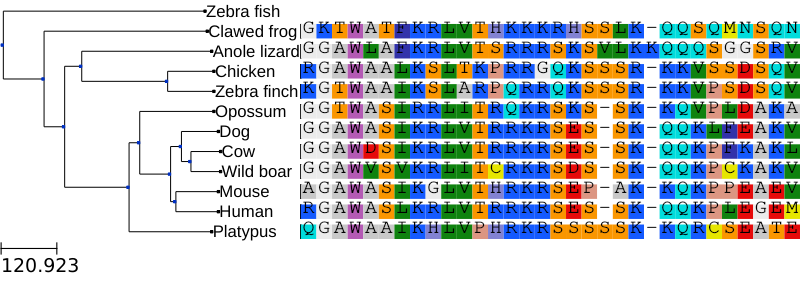

In [7]:
t = render_msa_phylo(nwk_direct, read_fasta(filename), host_guest_dict)
t.render("%%inline", w = 800)